<a href="https://colab.research.google.com/github/DevashishX/AbstractClustering/blob/master/templates/KmeansGlovePmeans5_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Requirements

This file has been modified for colab training, all outputs are stored in *ColabOutput* folder in your google drive, there is also a one copy in the normal training folders as well.
*Make sure you have ColabOutput folder in your google drive*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!git clone https://github.com/DevashishX/AbstractClustering.git; 
!cp -r AbstractClustering/* ./.

Cloning into 'AbstractClustering'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 624 (delta 38), reused 42 (delta 9), pack-reused 548
Receiving objects: 100% (624/624), 669.96 MiB | 31.25 MiB/s, done.
Resolving deltas: 100% (292/292), done.
Checking out files: 100% (368/368), done.


In [3]:
import subprocess
print((subprocess.check_output("lscpu", shell=True).strip()).decode())

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2300.000
BogoMIPS:            4600.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs 

# ***Set parameters***

In [0]:
__algo__ = "KMEANS"               #Name of the Clustering algorithm
__emb__ = "glove"                 #Name of the Word Embeddings used (glove, w2v, ftt), MUST set directory below
__sentemb__ = "pmeans5"           #Name of Sentence Embedding algorithm used
recnum = 30000                     #Number of records to be read from files
k = 350                           #Number of Clusters
usesqrt = False                   #Set value of k to sqrt of recnum, overrides k
randomsample = False              #Random Sampling to be True/False for records which are read
embedDir = "./MegaSentEmbs/"     #Directory where embeddings are saved for that selected embedding
modelDir = "./models/"           #Directory where models are saved
megadfDir = "./MegaDfs/"         #Directory Where Megadf is to be saved
plotDir = "./plots/"             #Directory where plots are saved
metadataDir = "./modelMetaData/" #Directory where performance and distribution params are to be stored
dumpDir = "./dump/"              #Directory where test outcomes are saved

# Actual Code

### imports and time

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import cluster, datasets
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns
import os, subprocess, sys
import datetime, time
import pickle

### File Settings

In [118]:
oldlist = os.listdir(embedDir)
filelist = sorted([embedDir+f for f in oldlist if f[-3:]=="pkl"])
filenum = len(filelist)
smalllist = filelist[:filenum]
print("Length of Smalllist: ", len(smalllist))

Length of Smalllist:  116


### Number of Records
It is Recommended to Set this at the top parameters

In [0]:
recnum = recnum

### Read all the pandas dataframes

In [120]:
%%time
megadf = pd.DataFrame()

if randomsample == True:
    print("randomsample: ", randomsample)
    for f in smalllist:
        tempdf = pd.read_pickle(f)
        megadf = megadf.append(tempdf, ignore_index = True)
    megadf = megadf.sample(recnum, random_state=42)
else:
    print("randomsample: ", randomsample)
    for f in smalllist:
        tempdf = pd.read_pickle(f)
        megadf = megadf.append(tempdf, ignore_index = True)
        if megadf.shape[0] >= recnum:
            megadf = megadf[:recnum]
            break

print("megadf.shape: ", megadf.shape)

randomsample:  False
megadf.shape:  (30000, 4)
CPU times: user 646 ms, sys: 177 ms, total: 823 ms
Wall time: 825 ms


In [121]:
predata = megadf["embedding"]
data = np.matrix(predata.to_list())
print(data.shape)

(30000, 250)


### Number of Clusters
It is Recommended to Set this at the top parameters

In [122]:
if usesqrt == True:
    print("usesqrt: ", usesqrt)
    sqrt_k = int(np.sqrt(data.shape[0]))
    k = int(sqrt_k)
else:
    print("usesqrt: ", usesqrt)
    k = k
print("k: ", k)

usesqrt:  False
k:  350


## Clustering
Please modify the functions here to change algorithm

In [123]:
%%time
print("Starting Clustering Process")
start_time = time.time()
model = cluster.KMeans(n_clusters=k, n_init = 20, max_iter=1000, verbose=1, n_jobs=-1)
model.fit(data)
end_time = time.time()
timetrain = round(end_time-start_time, 2)
print("done! {}".format(timetrain))
print("k_means.fit(data) Done!")

Starting Clustering Process


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


done! 890.59
k_means.fit(data) Done!
CPU times: user 223 ms, sys: 143 ms, total: 366 ms
Wall time: 14min 50s


### Saving the output data into vars

In [0]:
centroids = model.cluster_centers_
labels = model.labels_
megadf["clusterlabel"]=labels
centroidDF = pd.DataFrame(centroids)


## Plotting

Text(0.5, 1.0, 'KMEANS with k=350 records=30000 features=250 using glove')

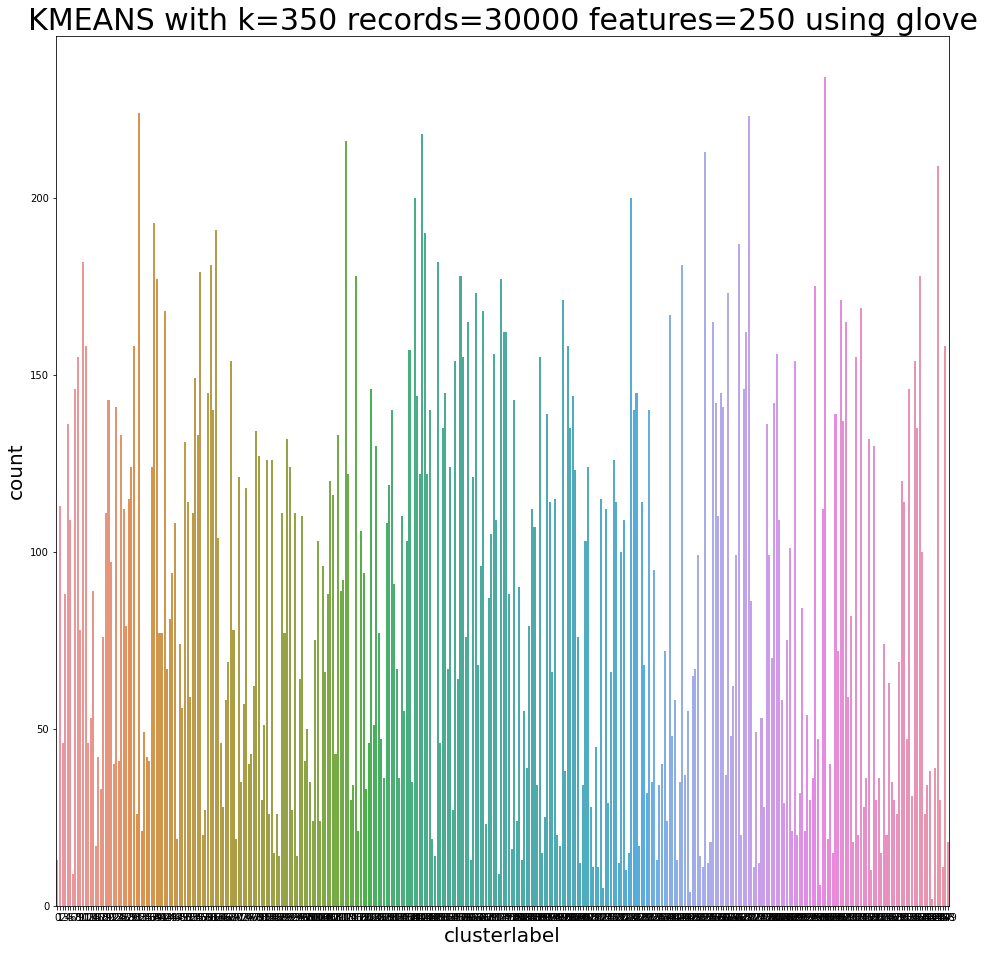

In [125]:
plt.figure(figsize=(16,16))
titlestring = "{} with k={} records={} features={} using {}".format(__algo__, k, data.shape[0], data.shape[1], __emb__)
snsplot = sns.countplot("clusterlabel", data=megadf)
snsplot.xaxis.label.set_size(20)
snsplot.yaxis.label.set_size(20)
plt.title(
        titlestring,
        fontdict = {'fontsize' : 30}
    )

### *Name given to saved files*

In [126]:
features = data.shape[1]
records = data.shape[0]
name = "{}_{}_{}_K{}_R{}_F{}".format(__algo__, __emb__, __sentemb__, k, records, features)
name

'KMEANS_glove_pmeans5_K350_R30000_F250'

### Saving Data

Save model

In [0]:
modelname = "{}_model.pkl".format(name)
pickle.dump(model, open(modelDir + modelname, 'wb'))
os.environ["SAVE_DF"] = modelDir + modelname
!cp $SAVE_DF ./drive/My\ Drive/ColabOutput/.

Save Plot

In [0]:
snspltname = "{}_plt.png".format(name)
snsplot.figure.savefig(plotDir + snspltname)
os.environ["SAVE_DF"] = plotDir + snspltname
!cp $SAVE_DF ./drive/My\ Drive/ColabOutput/.

Save Megadf

In [0]:
clusterdfname = "{}_clustered_megadf.pkl".format(name)
megadf.to_pickle(megadfDir + clusterdfname)
os.environ["SAVE_DF"] = megadfDir + clusterdfname
!cp $SAVE_DF ./drive/My\ Drive/ColabOutput/.

Save Centroids

In [130]:
centroidDF = pd.DataFrame(centroids)
centroidDFname = "{}_centroids.pkl".format(name)
centroidDF.to_pickle(megadfDir + centroidDFname)
os.environ["SAVE_DF"] = megadfDir + centroidDFname
!cp $SAVE_DF ./drive/My\ Drive/ColabOutput/.
print(centroidDF.shape)

(350, 250)


#### Open dataframe to test

In [131]:
sub = megadf.loc[:, ["id", "title", "abstract", "clusterlabel"]]
sub.tail()

,id,title,abstract,clusterlabel
29995,1639102,Age of onset of schizophrenia in siblings: A t...,"[original, article, found, http, www, scienced...",48
29996,1639103,Reducing persistent auditory hallucinations by...,"[copyright, british, psychological, society, f...",340
29997,1639104,Investigating Visual Knowledge in Dementia of ...,"[original, article, found, http, www, scienced...",48
29998,1639105,Monaural ear advantages in simple and choice r...,"[original, article, found, http, www, scienced...",48
29999,1639106,Routes to action in reaction time tasks,"[original, publication, available, www, spring...",43


In [132]:
megadf.columns

Index(['id', 'title', 'abstract', 'embedding', 'clusterlabel'], dtype='object')

# Performance Testing and Distribution


In [0]:
metadata = pd.DataFrame(columns=["Name", "Algo", "WordEmb", "SentEmb", "K", "R", "F", "SS", "CSavg", "CSmin", "CSmax", "T2Pavg", "T2LM", "T2LMP", "MEM"])

In [134]:
metadict = {
    "Name":None,                     #Name of the save file prefix
    "Algo":None,                     #Name of the Clustering algorithm
    "WordEmb":None,                  #Name of the Word Embeddings used (glove, w2v, ftt)
    "SentEmb":None,                  #Name of Sentence Embedding algorithm used 
    "K":None, "R":None, "F":None,    #Number of clusters, records and fetures
    "T2T":None,                      #Time required to train model
    "SS":None,                       #Silhoutte Score
    "DBS":None,                      #Davis Bouldin Score
    "CSavg":None,                    #Average Cluster Size
    "CSmin":None,                    #Minimum Cluster Size
    "CSmax":None,                    #Maximum Cluster Size
    "T2Pavg":None,                   #Average Time To Predict cluster of one record
    "T2LM":None,                     #Average Time to Load Model
    "T2LMP":None,                    #Amortized time to Predict after loading the model
    "MEM":None                      #Memory used by the Model
    }
metadict

{'Algo': None,
 'CSavg': None,
 'CSmax': None,
 'CSmin': None,
 'DBS': None,
 'F': None,
 'K': None,
 'MEM': None,
 'Name': None,
 'R': None,
 'SS': None,
 'SentEmb': None,
 'T2LM': None,
 'T2LMP': None,
 'T2Pavg': None,
 'T2T': None,
 'WordEmb': None}

In [135]:
metadict["Name"]=name
metadict["Algo"]=__algo__
metadict["WordEmb"]=__emb__
metadict["SentEmb"]=__sentemb__
metadict["K"]=k
metadict["R"]=recnum
metadict["F"]=features
metadict

{'Algo': 'KMEANS',
 'CSavg': None,
 'CSmax': None,
 'CSmin': None,
 'DBS': None,
 'F': 250,
 'K': 350,
 'MEM': None,
 'Name': 'KMEANS_glove_pmeans5_K350_R30000_F250',
 'R': 30000,
 'SS': None,
 'SentEmb': 'pmeans5',
 'T2LM': None,
 'T2LMP': None,
 'T2Pavg': None,
 'T2T': None,
 'WordEmb': 'glove'}

#### Time to train

In [0]:
metadict["T2T"]=timetrain

#### Scores

In [0]:
ss = silhouette_score(data, labels, metric = 'euclidean')
dbs = davies_bouldin_score(data, labels)
metadict["SS"]=ss
metadict["DBS"]=dbs

#### Cluster Size

In [138]:
clusterdata = megadf.groupby("clusterlabel", as_index=True).size().reset_index(name="count")
clusterdata.head()

,clusterlabel,count
0,0,13
1,1,113
2,2,46
3,3,88
4,4,136


In [0]:
clusterdfname = "{}_clustered_counts.pkl".format(name)
clusterdata.to_pickle(megadfDir + clusterdfname)
os.environ["SAVE_DF"] = megadfDir + clusterdfname
!cp $SAVE_DF ./drive/My\ Drive/ColabOutput/.

In [140]:
countdata = clusterdata.groupby("count").size().reset_index(name="clusters")
display(countdata.head(3))
display(countdata.tail(3))

,count,clusters
0,2,1
1,4,1
2,5,1


,count,clusters
152,223,1
153,224,1
154,234,1


In [0]:
metadict["CSmax"] = max(clusterdata["count"])
metadict["CSmin"] = min(clusterdata["count"])
metadict["CSavg"] = np.mean(clusterdata["count"])

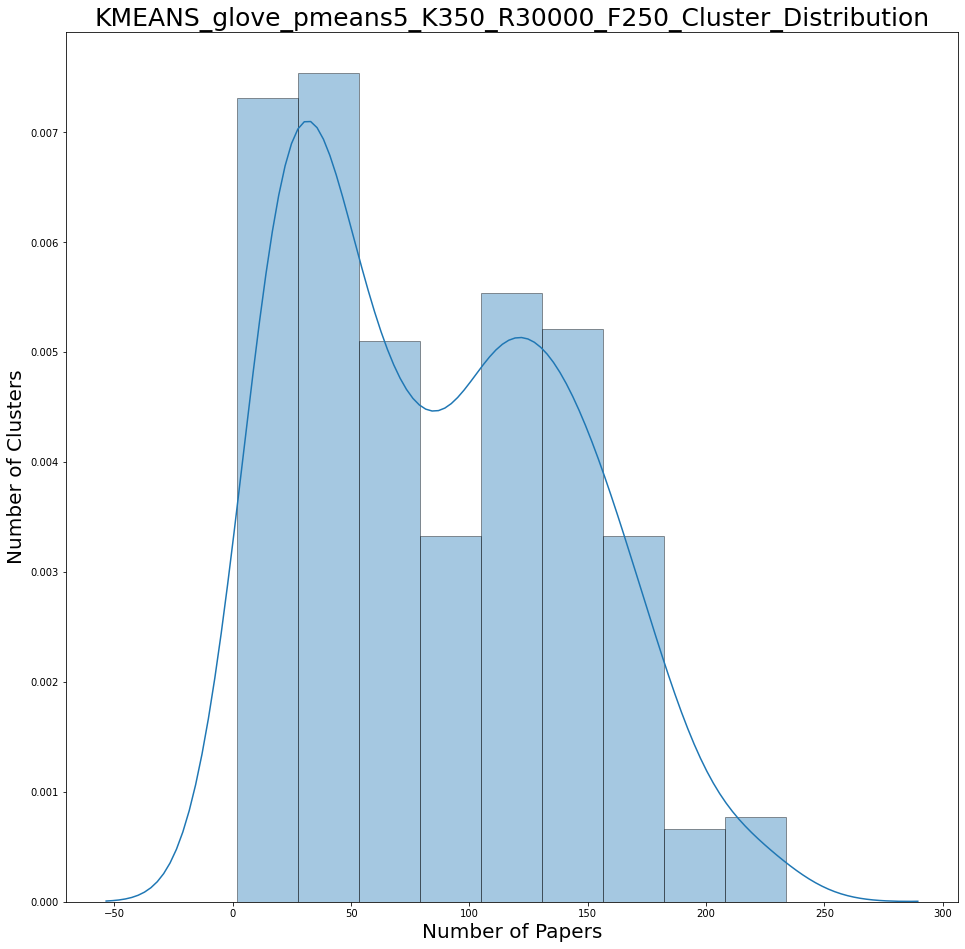

In [155]:
%matplotlib inline
plt.figure(figsize=(16,16))

sns.axes_style("whitegrid", {"axes.grid":True, 
                            'axes.spines.left': False,
                             'axes.spines.bottom': False,
                             'axes.spines.right': False,
                             'axes.spines.top': False})


titlestring = "{}_Cluster_Distribution".format(name)
snsplot = sns.distplot(clusterdata["count"], 
                       kde=True, 
                    #    bins=len(clusterdata["count"]),
                      hist_kws={'edgecolor':'black'},)
snsplot.set(xlabel="Number of Papers", ylabel="Number of Clusters")
snsplot.xaxis.label.set_size(20)
snsplot.yaxis.label.set_size(20)
plt.title(
        titlestring,
        fontdict = {'fontsize' : 25}
    )
plt.show()



In [0]:
snspltname = "{}_Cluster_Distribution.png".format(name)
snsplot.figure.savefig(plotDir + snspltname)
os.environ["SAVE_DF"] = plotDir + snspltname
!cp $SAVE_DF ./drive/My\ Drive/ColabOutput/.

#### Prediction Time Performance

In [144]:
testdf = pd.DataFrame()
if recnum < 2000:
    samplenum = int(recnum / 10)
else:
    samplenum = 2000

for f in smalllist:
    tempdf = pd.read_pickle(f)
    testdf = megadf.append(tempdf, ignore_index = True, sort = False)
testdf = testdf.sample(samplenum, random_state=int(time.time()%100000))
predata = testdf["embedding"]
data = np.matrix(predata.to_list())
print(data.shape)

(2000, 250)


In [145]:
print("Starting Predicting Performance")
testmodel = model
start_time = time.time()
for d in data:
    lb = testmodel.predict(d)
end_time = time.time()
timetest = end_time-start_time
avgtime = timetest/data.shape[0]
print("Avgtime: {} Totaltime: {}".format(avgtime, timetest))
metadict["T2Pavg"]=avgtime

Starting Predicting Performance
Avgtime: 0.0008863788843154907 Totaltime: 1.7727577686309814


In [146]:
print("Starting Loading Performance")
loadruns = 50
start_time = time.time()
for i in range(loadruns):
    testmodel = pickle.load(open(modelDir + modelname, 'rb'))
end_time = time.time()
timetest = end_time-start_time
avgtime = timetest/loadruns
print("Avgtime: {} Totaltime: {}".format(avgtime, timetest))
metadict["T2LM"] = avgtime
avgtime

Starting Loading Performance
Avgtime: 0.0005214643478393554 Totaltime: 0.026073217391967773


0.0005214643478393554

In [147]:
print("Starting Amortized Performance")
loadruns = 5
avglist = []

for i in range(loadruns):
    start_time = time.time()
    testmodel = pickle.load(open(modelDir + modelname, 'rb'))
    for d in data:
        lb = testmodel.predict(d)
    end_time = time.time()
    timetest = (end_time-start_time)/data.shape[0]
    avglist.append(timetest)

timetest = np.sum(avglist)
avgtime = np.mean(avglist)
print("Avgtime: {} Totaltime: {}".format(avgtime, timetest))
metadict["T2LMP"] = avgtime
avgtime

Starting Amortized Performance
Avgtime: 0.000887313461303711 Totaltime: 0.004436567306518555


0.000887313461303711

In [148]:
modelsize = sys.getsizeof(pickle.dumps(model))
print("modelsize:", modelsize, "bytes")
metadict["MEM"]=modelsize

modelsize: 820749 bytes


In [149]:
metadict

{'Algo': 'KMEANS',
 'CSavg': 85.71428571428571,
 'CSmax': 234,
 'CSmin': 2,
 'DBS': 3.413832029565413,
 'F': 250,
 'K': 350,
 'MEM': 820749,
 'Name': 'KMEANS_glove_pmeans5_K350_R30000_F250',
 'R': 30000,
 'SS': 0.04121838448692947,
 'SentEmb': 'pmeans5',
 'T2LM': 0.0005214643478393554,
 'T2LMP': 0.000887313461303711,
 'T2Pavg': 0.0008863788843154907,
 'T2T': 890.59,
 'WordEmb': 'glove'}

In [150]:
metadata = metadata.append(metadict, ignore_index=True)
metadata

,Name,Algo,WordEmb,SentEmb,K,R,F,SS,CSavg,CSmin,CSmax,T2Pavg,T2LM,T2LMP,MEM,DBS,T2T
0,KMEANS_glove_pmeans5_K350_R30000_F250,KMEANS,glove,pmeans5,350,30000,250,0.041218,85.714286,2,234,0.000886,0.000521,0.000887,820749,3.413832,890.59


In [0]:
metadataname = "{}_metadata.pkl".format(name)
metadata.to_pickle(metadataDir + metadataname)
os.environ["SAVE_DF"] = metadataDir + metadataname
!cp $SAVE_DF ./drive/My\ Drive/ColabOutput/.

In [152]:
print("All Done!\nCheck ColabOutput!")

All Done!
Check ColabOutput!
